In [43]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [83]:
# Funcion para agregar las señales de MACD
def add_macd_signals(df):
    df['MACD_Buy_Signal_lag1'] = (
        (df['MACD_12_26_9_lag1'] > df['MACDs_12_26_9_lag1']) &
        (df['MACD_12_26_9_lag1'].shift(1) <= df['MACDs_12_26_9_lag1'].shift(1))
    ).astype(int)

    df['MACD_Sell_Signal_lag1'] = (
        (df['MACD_12_26_9_lag1'] < df['MACDs_12_26_9_lag1']) &
        (df['MACD_12_26_9_lag1'].shift(1) >= df['MACDs_12_26_9_lag1'].shift(1))
    ).astype(int)

    return df

# Funcion para agregar las señales de Bollinger Bands
def add_bollinger_features(df):
    df['BBW_lag1']             = df['BBU_20_2.0_lag1'] - df['BBL_20_2.0_lag1']
    df['BB%B_lag1']            = (df['Close_lag_1'] - df['BBL_20_2.0_lag1']) / (df['BBU_20_2.0_lag1'] - df['BBL_20_2.0_lag1'])
    df['Squeeze_lag1']         = (df['BBB_20_2.0_lag1'] < 0.02).astype(int)
    df['Breakout_lag1']        = (
        (df['Close_lag_1'] > df['BBU_20_2.0_lag1']) |
        (df['Close_lag_1'] < df['BBL_20_2.0_lag1'])
    ).astype(int)
    df['Dist_from_Middle_lag1'] = df['Close_lag_1'] - df['BBM_20_2.0_lag1']
    df['Z_Score_lag1']         = df['Dist_from_Middle_lag1'] / ((df['BBU_20_2.0_lag1'] - df['BBM_20_2.0_lag1']) / 2)
    df['BB_Ratio_lag1']        = df['BBU_20_2.0_lag1'] / df['BBL_20_2.0_lag1']
    
    return df

def add_lag1_technical_indicators(df):
    df['Close_lag_1'] = df['Close'].shift(1)

    # SMA y RSI sobre Close_lag_1
    df['SMA_20_lag1'] = ta.sma(df['Close_lag_1'], length=20)
    df['SMA_50_lag1'] = ta.sma(df['Close_lag_1'], length=50)
    df['RSI_14_lag1'] = ta.rsi(df['Close_lag_1'], length=14)

    # MACD sobre Close_lag_1
    macd = ta.macd(df['Close_lag_1'])
    macd = macd.rename(columns={
        'MACD_12_26_9':  'MACD_12_26_9_lag1',
        'MACDh_12_26_9': 'MACDh_12_26_9_lag1',
        'MACDs_12_26_9': 'MACDs_12_26_9_lag1'
    })
    df = pd.concat([df, macd], axis=1)

    # Bollinger Bands sobre Close_lag_1
    bb = ta.bbands(df['Close_lag_1'], length=20)
    bb = bb.rename(columns={
        'BBL_20_2.0': 'BBL_20_2.0_lag1',
        'BBM_20_2.0': 'BBM_20_2.0_lag1',
        'BBU_20_2.0': 'BBU_20_2.0_lag1',
        'BBB_20_2.0': 'BBB_20_2.0_lag1',
        'BBP_20_2.0': 'BBP_20_2.0_lag1'
    })
    df = pd.concat([df, bb], axis=1)  

    df = add_bollinger_features(df)
    df = add_macd_signals(df) 

    return df

#Funcion para agregar las features de covid
def add_covid_info(df):
    df['days_since_covid_begin'] = (df['Date'] - pd.to_datetime('2020-03-11')).dt.days
    df['days_since_covid_end'] = (df['Date'] - pd.to_datetime('2023-05-05')).dt.days
    return df

#Funcion para agregar las features de estaciones
def add_seasons(df, as_dummies=False):
    month = df['Date'].dt.month
    df['season'] = month.map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    })

    if as_dummies:
        season_dummies = pd.get_dummies(df['season'], prefix='season', drop_first=True)
        df = df.drop(columns='season')
        df = pd.concat([df, season_dummies], axis=1)

    return df

def day_month_year(df):
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['day_of_week'] = df['Date'].dt.dayofweek
    return df

#Funcion para agregar las features de lags
def lag_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

# Funcion para agregar todas las features generadas
def feature_engineering(df, percentage=0.1, k=0.01):
    print(k)
    print(f"Dataset before feature engineering: {df.shape}")
    df['Date'] = pd.to_datetime(df['Date'])
    # df = add_lag1_technical_indicators(df)
    df = add_covid_info(df)
    df = add_seasons(df, as_dummies=True)
    df = day_month_year(df)
    df = lag_features(df, 'Close', list(range(1, 16)))
    
    for col in [col for col in df.columns if 'SP500' in col]:
        df = lag_features(df, col, [1])
        df.drop(columns=[col], inplace=True)

    for col in ['Volume', 'Open', 'High', 'Low']:
        df = lag_features(df, col, [1])
        df.drop(columns=[col], inplace=True)

    df.dropna(inplace=True)
    #Arreglo de distribución de probabilidad. Mientras más lejos este de la fecha más reciente, menos probabilidad tiene de ser traida.
    # Asignamos pesos que van de menor a mayor (más antiguo = menos peso)

    valoresX=[i+1 for i in range(len(df))]
    valoresX = np.array(valoresX)
    # #Normalizar los valoresX con standardScaler 
    # valoresX= StandardScaler().fit_transform(valoresX.reshape(-1, 1))
    # valoresX = valoresX.flatten()  # Convertir de nuevo a 1D
    # #Mover los valores para que el minimo sea 0
    # offset=abs(valoresX.min())
    # valoresX=valoresX+offset
    print(f"Valores X: {valoresX}")
    distribucion = k*np.exp(-k*valoresX)  # pesos decrecientes


    #Dar la vuelta a la distribución para que los más recientes tengan más peso
    distribucion = distribucion[::-1]
    distribucion = pd.Series(distribucion, index=df.index)
    print(distribucion.sum())
    print(distribucion.isna().sum())
    plt.figure(figsize=(10, 5))
    plt.plot([i for i in range(len(distribucion))], distribucion)
    plt.title('Distribution of weights')
    
    print(f"Distribution of weights: {distribucion}")
    # Se pasa la distribución a una función de selección de datos aleatoria, 
    # el tamaño estará dado por el parametro percentage
    df2 = df.sample(frac=percentage, weights=distribucion, random_state=11)
   
        #Convertir Date a tipo datetime
    df2['Date'] = pd.to_datetime(df2['Date'])
    plt.figure(figsize=(10, 5))
    plt.hist(df2['Date'], bins=30)
    plt.title('Histogram of Dates with more weight in recent data')

     #Se dropea date ya que no se necesita para el modelo


    df2.drop(columns=['Date'], inplace=True)

    print(f"Dataset after feature engineering: {df2.shape}")
    plt.show()
    return df2

0.0005
Dataset before feature engineering: (11144, 11)
Valores X: [    1     2     3 ... 11127 11128 11129]
0.9959194828131694
0
Distribution of weights: 15       0.000002
16       0.000002
17       0.000002
18       0.000002
19       0.000002
           ...   
11139    0.000499
11140    0.000499
11141    0.000499
11142    0.000500
11143    0.000500
Length: 11129, dtype: float64
Dataset after feature engineering: (3339, 34)


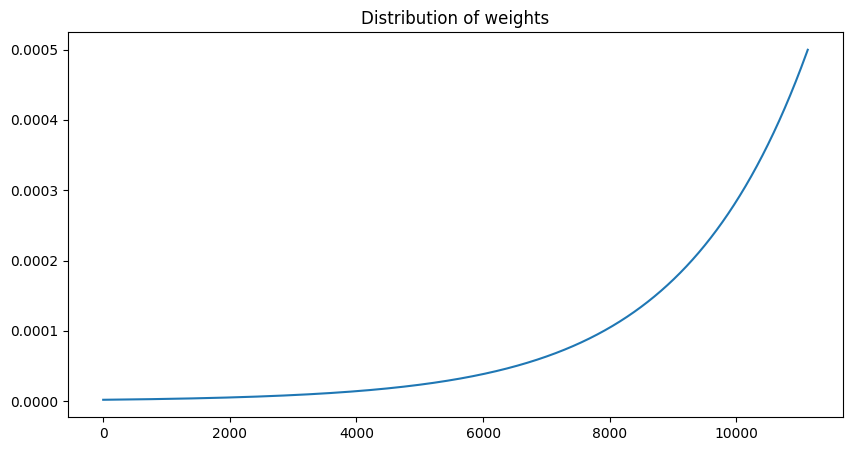

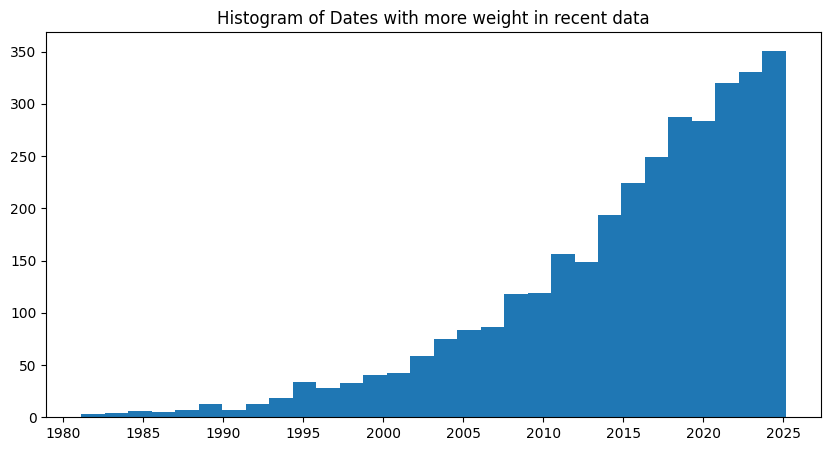

In [84]:
apple_data = pd.read_csv('../data/processed/AAPL_with_SP500_clean.csv')

# apple_data= apple_data[apple_data['Date']>'2022-01-01']

apple_data = feature_engineering(apple_data, percentage=0.3, k=0.0005)



In [85]:
#Ver duplicados
duplicates = apple_data[apple_data.duplicated()]
print(f"Duplicated rows: {duplicates.shape[0]}")

Duplicated rows: 0


In [86]:

# apple_data.drop(columns=['Volume_lag_1', 'Volume_SP500_lag_1', 'High_lag_1','Low_lag_1', 'Open_lag_1','Close_lag_1'
#                          , 'Open_SP500_lag_1', 'High_SP500_lag_1','Low_SP500_lag_1', 'Close_SP500_lag_1', 'days_since_covid_begin'
#                             , 'days_since_covid_end', 'day', 'month', 'year', 'day_of_week'
#                          ], inplace=True)
# apple_data.info()

7974      17.887640
6242       1.405371
10513    165.123027
8537      21.595213
10604    125.431607
Name: Close, dtype: float64
MSE: 1.1189908803780668
R2: 0.9997834238011795


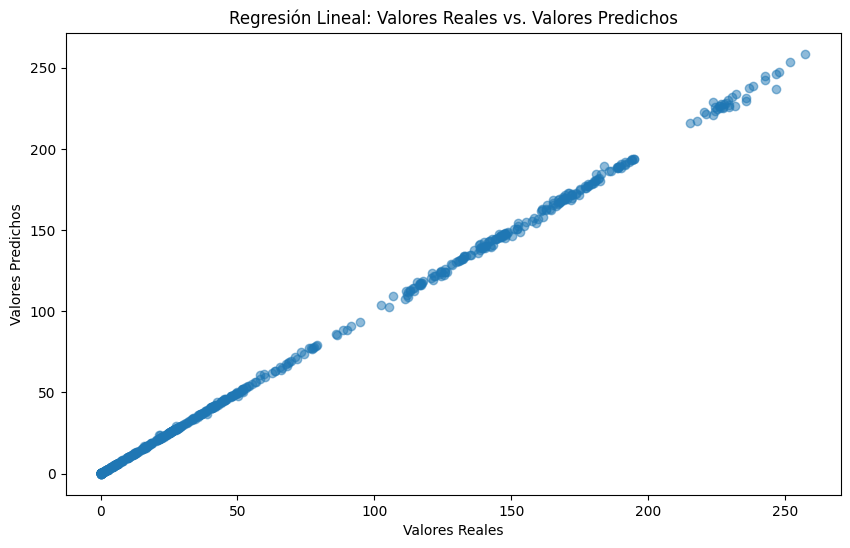

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Preparar los datos para el entrenamiento
train_data, test_data = train_test_split(apple_data, test_size=0.2, random_state=42, shuffle=True)

y_train = train_data['Close']
X_train = train_data.drop(columns=['Close'])

y_test = test_data['Close']
print(y_test.head())
X_test = test_data.drop(columns=['Close'])   

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)  

print(f"MSE: {mse}")
print(f"R2: {r2}")

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión Lineal: Valores Reales vs. Valores Predichos')
plt.show()